In [53]:
import pyreadr
import numpy as np
import pandas as pd
from pymatreader import read_mat
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression#, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from pytictoc import TicToc

In [2]:
def recursionStart(spectra):
    featurePairs = []
    maxima = []
    minima = []
    
    for i in range(1, len(spectra) - 1):
        if spectra[i] > spectra[i-1]:
            if spectra[i] >= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] > spectra[j]:
                        maxima.append([i, spectra[i]])
                        break
                    elif spectra[i] < spectra[j]:
                        break
        if spectra[i] < spectra[i-1]:
            if spectra[i] <= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] < spectra[j]:
                        minima.append([i, spectra[i]])
                        break
                    elif spectra[i] > spectra[j]:
                        break
    maxima.sort(key = lambda element: element[1], reverse = True)
    minima.sort(key = lambda element: element[1])
    
    globalMaxima = maxima.pop(0)
    featurePairs.append([globalMaxima[0], globalMaxima[1] - minima[0][1]])
    
    recursionStep(0, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    recursionStep(len(spectra) - 1, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    
    return featurePairs

def recursionStep(start, end, maxima, minima, featurePairs):
    factor = 1
    if end < start:
        factor = -1
    currentMaxima = []
    for i in range(len(maxima)):
        position = maxima[i][0]
        if start * factor < position * factor and position * factor < end * factor:
            currentMaxima.append(maxima[i])
    if len(currentMaxima) == 0:
        return
    localMaxima = currentMaxima.pop(0)
    recursionStep(start, localMaxima[0], currentMaxima.copy(), minima.copy(), featurePairs)
    currentMinima = []
    for i in range(len(minima)):
        position = minima[i][0]
        if localMaxima[0] * factor < position * factor and position * factor < end:
            currentMinima.append(minima[i])
    localMinima = currentMinima.pop(0)
    featurePairs.append([localMaxima[0], localMaxima[1] - localMinima[1]])
    recursionStep(localMinima[0], localMaxima[0], currentMaxima.copy(), currentMinima.copy(), featurePairs)
    recursionStep(localMinima[0], end, currentMaxima.copy(), currentMinima.copy(), featurePairs)

In [3]:
def getPersistenceTransformation(data_X, listOfK):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X.iloc[i])
        featurePairs.sort(key = lambda element: element[1], reverse = True)
        spectras.append(featurePairs)
        
    spectrasForEachK = []
    
    for k in listOfK:
        transformationForSpectra = []
        for i in range(0, len(spectras)):
            transformation = [0] * len(data_X.iloc[i])
            featurePairs = spectras[i][0:round(k*len(spectras[i]))]
            for x, fx in featurePairs:
                transformation[x] = fx
            transformationForSpectra.append(transformation)
        spectrasForEachK.append(transformationForSpectra)
    return spectrasForEachK

In [4]:

def cvAccuracy(tmas, X, resp, classifier):
    
    tmas_names = ['TMA_1:', 'TMA_2:', 'TMA_3:', 'TMA_4:', 'TMA_5:', 'TMA_6:', 'TMA_7:', 'TMA_8:']
    
    tmas_res_test   = []
    tmas_vals_test  = []
    tmas_res_train  = []
    tmas_vals_train = []
    
    for tma in range(1, len(tmas_names)+1):
    
        X_train = X.iloc[tmas[tmas != tma].index, :]

        X_test = X.iloc[tmas[tmas == tma].index, :]

        y_train = resp.iloc[tmas[tmas != tma].index, :]

        y_test = resp.iloc[tmas[tmas == tma].index, :]
        
        if (classifier == 'log'):

            logreg = LogisticRegression(penalty = 'none', solver = 'newton-cg')

            logreg.fit(X_train, y_train.values.ravel())

            y_pred = logreg.predict_proba(X_test)

            y_pred_1 = np.where(y_pred[:, 1] > 0.5, 1, 0)

            accuracy = balanced_accuracy_score(y_test, y_pred_1)
            
            tmas_vals_test.append(accuracy)

            tmp_tmas = [tmas_names[tma-1], accuracy]

            tmas_res_test.append(tmp_tmas)
            
        if (classifier == 'rf'):
            
            rf = RandomForestClassifier(n_estimators= 500, random_state= 1234)
            
            rf.fit(X_train, y_train.values.ravel())
            
            y_pred_rf = rf.predict(X_test)
            
            accuracy = balanced_accuracy_score(y_test, y_pred_rf)
            
            tmas_vals_test.append(accuracy)

            tmp_tmas = [tmas_names[tma-1], accuracy]

            tmas_res_test.append(tmp_tmas)
        
    return tmas_vals_test, tmas_res_test  

def Average(lst):
    return sum(lst) / len(lst)
    

In [5]:
# Loading Data from Matlab
dataMaldi = read_mat('data/L1-8_tic_ad_sq.mat')

X_values = pd.DataFrame(dataMaldi['data_tic'])#Reading the mz-values 
                                #to get pd's as input for the ml
classes = pd.DataFrame(dataMaldi['classes'])#The cancer Typ, result for ml

mz_values = pd.DataFrame(dataMaldi['mzVector'])

TMAs   = pd.Series(dataMaldi['tmas'])

p = X_values.shape[0]

y = pd.DataFrame(np.where(classes == 1, 0, 1))

In [6]:
listOfk = [0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5]
ListOfXk = getPersistenceTransformation(data_X = X_values, listOfK = listOfk)
X_k1 = ListOfXk[0]
X_k2 = ListOfXk[1]
X_k3 = ListOfXk[2]
X_k4 = ListOfXk[3]
X_k5 = ListOfXk[4]
X_k6 = ListOfXk[5]
X_k7 = ListOfXk[6]

In [54]:
q1, q2 = cvAccuracy(tmas =TMAs, resp=y, X = X_values, classifier='log')
res_k1_1, res_k1_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k1), classifier = 'log')
res_k2_1, res_k2_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k2), classifier = 'log')
res_k3_1, res_k3_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k3), classifier = 'log')
res_k4_1, res_k4_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k4), classifier = 'log')
res_k5_1, res_k5_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k5), classifier = 'log')
res_k6_1, res_k6_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k6), classifier = 'log')
res_k7_1, res_k7_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k7), classifier = 'log')

Elapsed time is 22.083912 seconds.


In [63]:
rf_raw_1, rf_raw_2 = cvAccuracy(tmas =TMAs, resp=y, X = X_values, classifier='rf')
rf_k1_1, rf_k1_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k1), classifier = 'rf')
rf_k2_1, rf_k2_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k2), classifier = 'rf')
rf_k3_1, rf_k3_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k3), classifier = 'rf')
rf_k4_1, rf_k4_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k4), classifier = 'rf')
rf_k5_1, rf_k5_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k5), classifier = 'rf')
rf_k6_1, rf_k6_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k6), classifier = 'rf')
rf_k7_1, rf_k7_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k7), classifier = 'rf')

In [69]:
results_as_tables_rf = pd.concat([pd.DataFrame(rf_raw_1).describe(), pd.DataFrame(rf_k1_1).describe(),
                              pd.DataFrame(rf_k2_1).describe(), pd.DataFrame(rf_k3_1).describe(),
                              pd.DataFrame(rf_k4_1).describe(), pd.DataFrame(rf_k5_1).describe(),
                              pd.DataFrame(rf_k6_1).describe(), pd.DataFrame(rf_k7_1).describe()],
                              axis=1)

results_rf_to_latex = round(results_as_tables_rf, 3)

pd.DataFrame(results_rf_to_latex).to_latex('results/results_rf_to_latex.tex')

C:\Users\vkvut\AppData\Local\Temp/ipykernel_20008/3478243968.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.DataFrame(results_rf_to_latex).to_latex('results/results_rf_to_latex.tex')


In [62]:
results_as_tables = pd.concat([pd.DataFrame(res_k1_1).describe(), pd.DataFrame(res_k2_1).describe(),
                              pd.DataFrame(res_k3_1).describe(), pd.DataFrame(res_k4_1).describe(),
                              pd.DataFrame(res_k5_1).describe(), pd.DataFrame(res_k6_1).describe(),
                              pd.DataFrame(res_k7_1).describe(), pd.DataFrame(q1).describe()],
                              axis=1)
results_to_latex = round(results_as_tables, 3)

pd.DataFrame(results_to_latex).to_latex('results/logit_results.tex')




C:\Users\vkvut\AppData\Local\Temp/ipykernel_20008/1529332034.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.DataFrame(results_to_latex).to_latex('results/logit_results.tex')


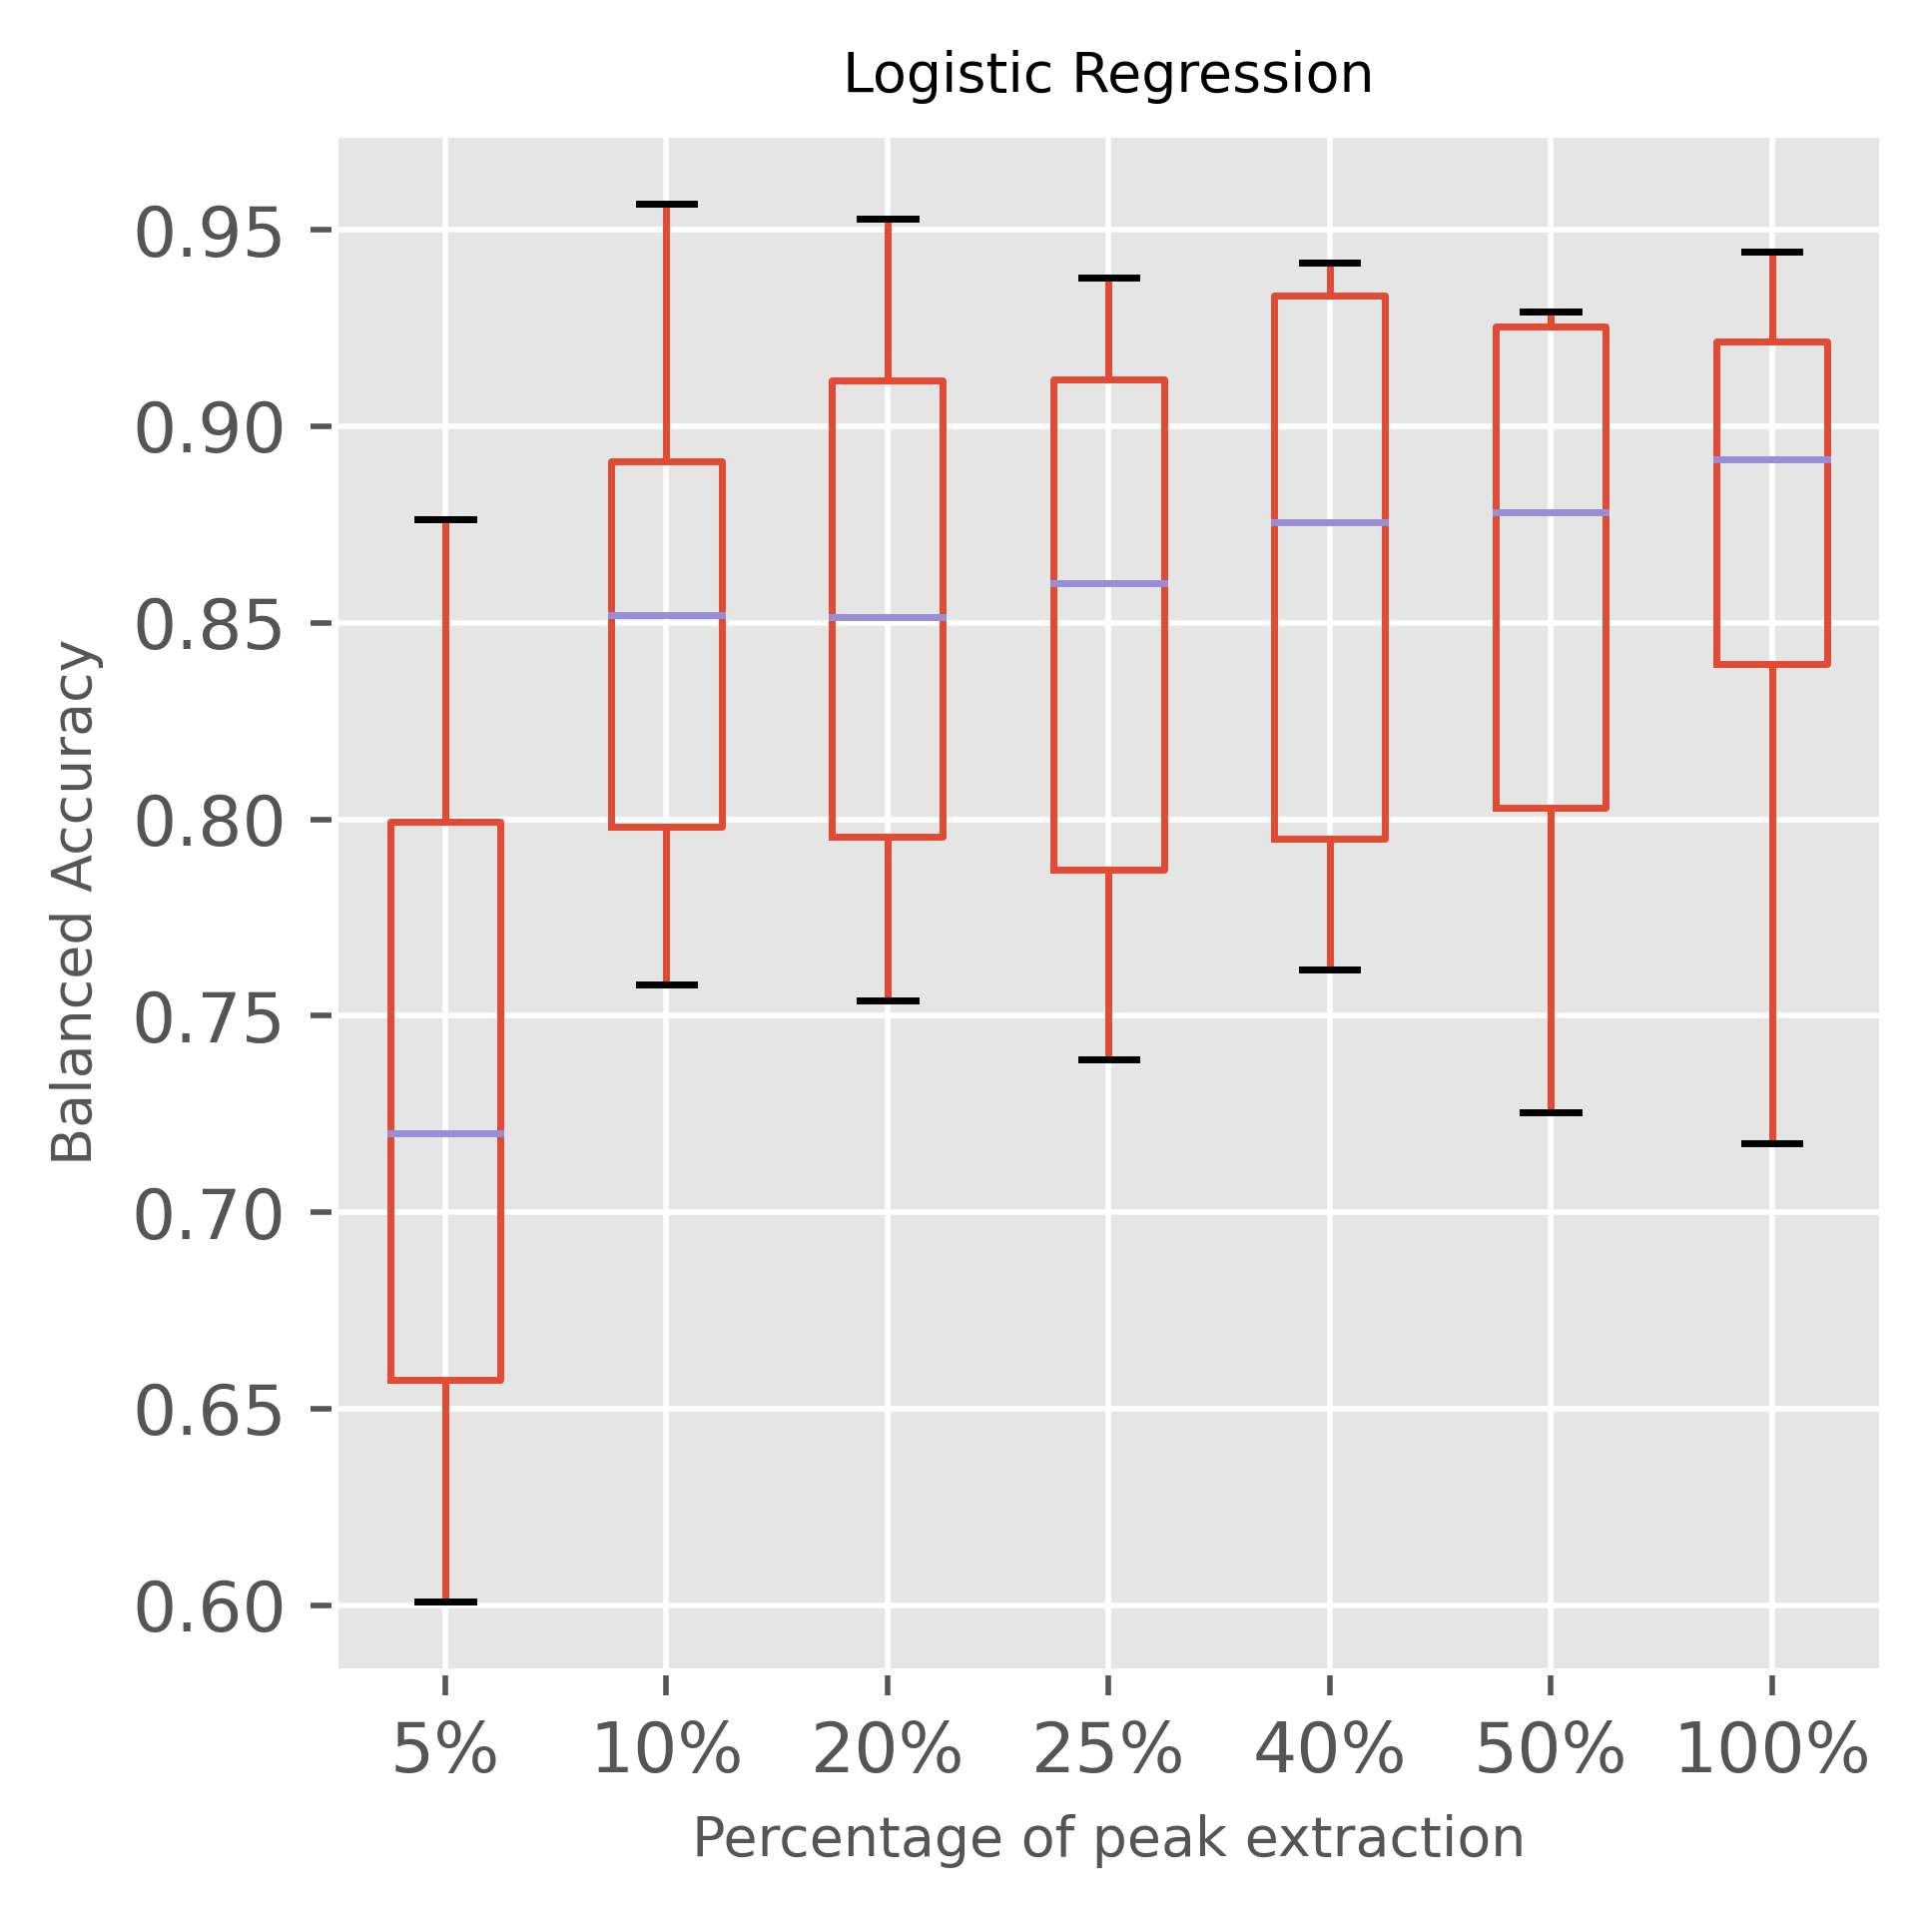

In [31]:
matplotlib.style.use('ggplot')

fig = plt.figure(figsize=(4, 4), dpi=500)
results = pd.concat([pd.Series(res_k2_1), pd.Series(res_k3_1), 
                     pd.Series(res_k4_1), pd.Series(res_k5_1),
                     pd.Series(res_k6_1), pd.Series(res_k7_1), pd.Series(q1)], axis=1)

results = pd.DataFrame(results)

box = results.boxplot()

#[0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5]
box.set_xticklabels(['5%', '10%','20%', '25%', '40%', '50%', '100%'])
box.set_xlabel('Percentage of peak extraction', fontsize=8)
box.set_ylabel('Balanced Accuracy', fontsize=8)
box.set_title('Logistic Regression', fontsize=8)
#sns.boxplot(results.iloc[:, 0:1])
plt.savefig("results/balanced_accuracy_logit.pdf", format="pdf", bbox_inches="tight")

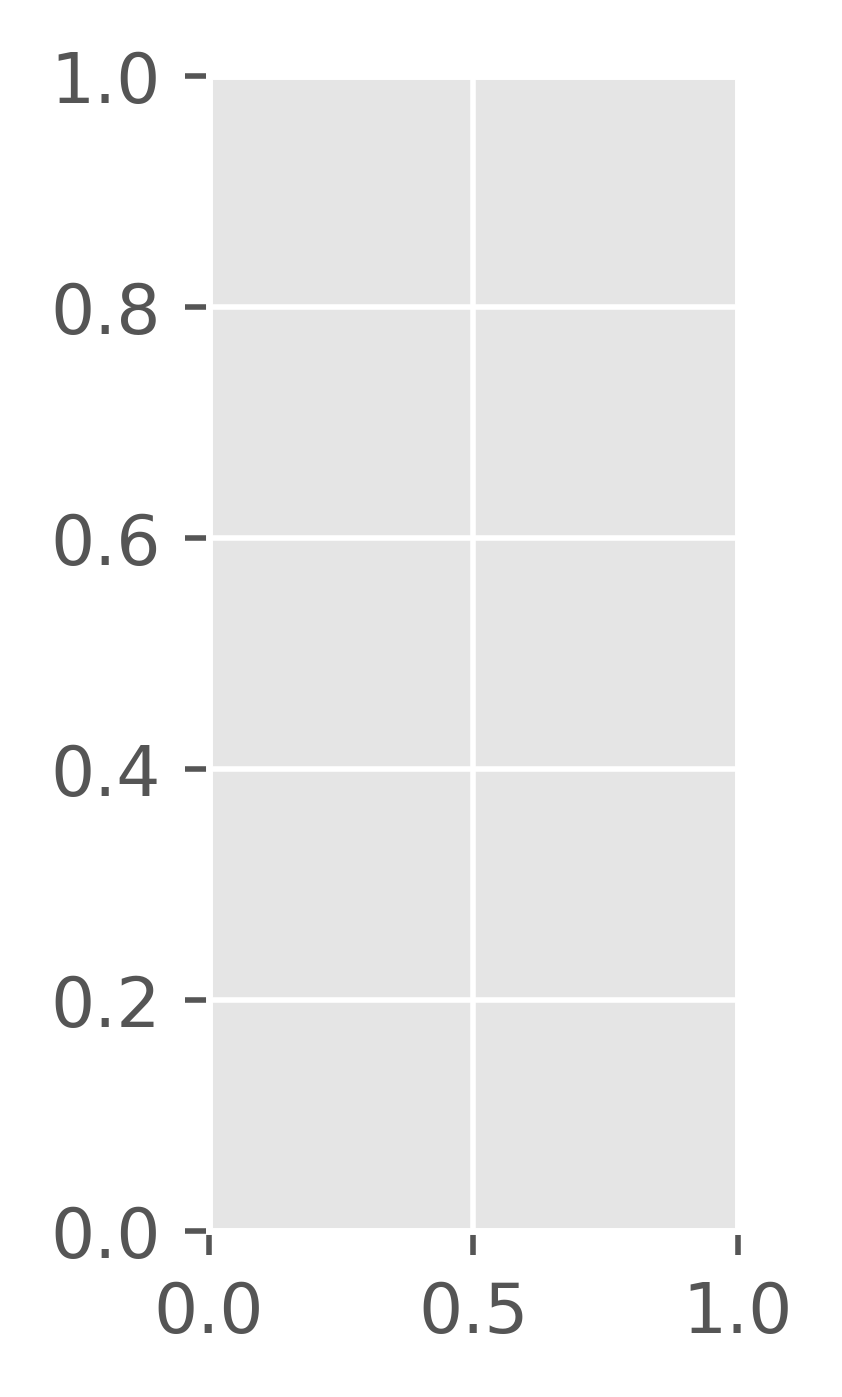

<Figure size 640x480 with 0 Axes>

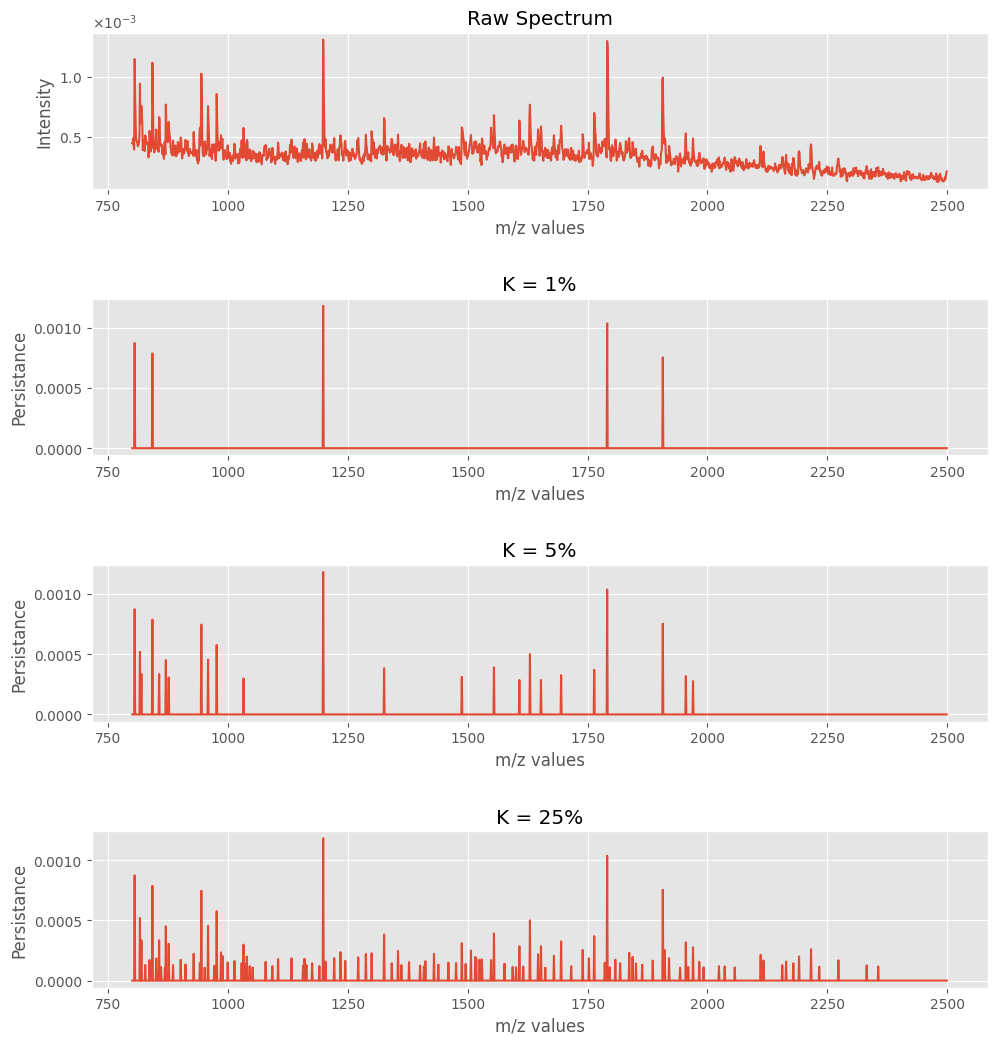

In [32]:
matplotlib.style.use('ggplot')

fig = plt.figure(figsize=(3, 3), dpi=500)

plt.subplot(1, 2, 1)

s1 = X_values.loc[[22]]
s2 = pd.DataFrame(X_k1).loc[[22]]
s3 = pd.DataFrame(X_k2).loc[[22]]
s4 = pd.DataFrame(X_k5).loc[[22]]

fig = plt.figure()

fig, ax = plt.subplots(4, 1)


ax[0].plot(mz_values, np.transpose(s1))

ax[0].ticklabel_format(axis='y',style='sci',scilimits=(-3, -3), useMathText = True)
ax[0].set_ylabel('Intensity')
ax[0].set_xlabel('m/z values')
ax[0].set_title("Raw Spectrum")

#.subplot(2, 2, 2) # index 2
ax[1].plot(mz_values, np.transpose(s2))
ax[1].set_ylabel('Persistance')
ax[1].set_xlabel('m/z values')
ax[1].set_title("K = 1%")

ax[2].plot(mz_values, np.transpose(s3))
ax[2].set_ylabel('Persistance')
ax[2].set_xlabel('m/z values')
ax[2].set_title("K = 5%")

ax[3].plot(mz_values, np.transpose(s4))
ax[3].set_ylabel('Persistance')
ax[3].set_xlabel('m/z values')
ax[3].set_title("K = 25%")

plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=2,
                    wspace=0.6,
                    hspace=0.7)

plt.savefig("results/persistance.pdf", format="pdf", bbox_inches="tight")


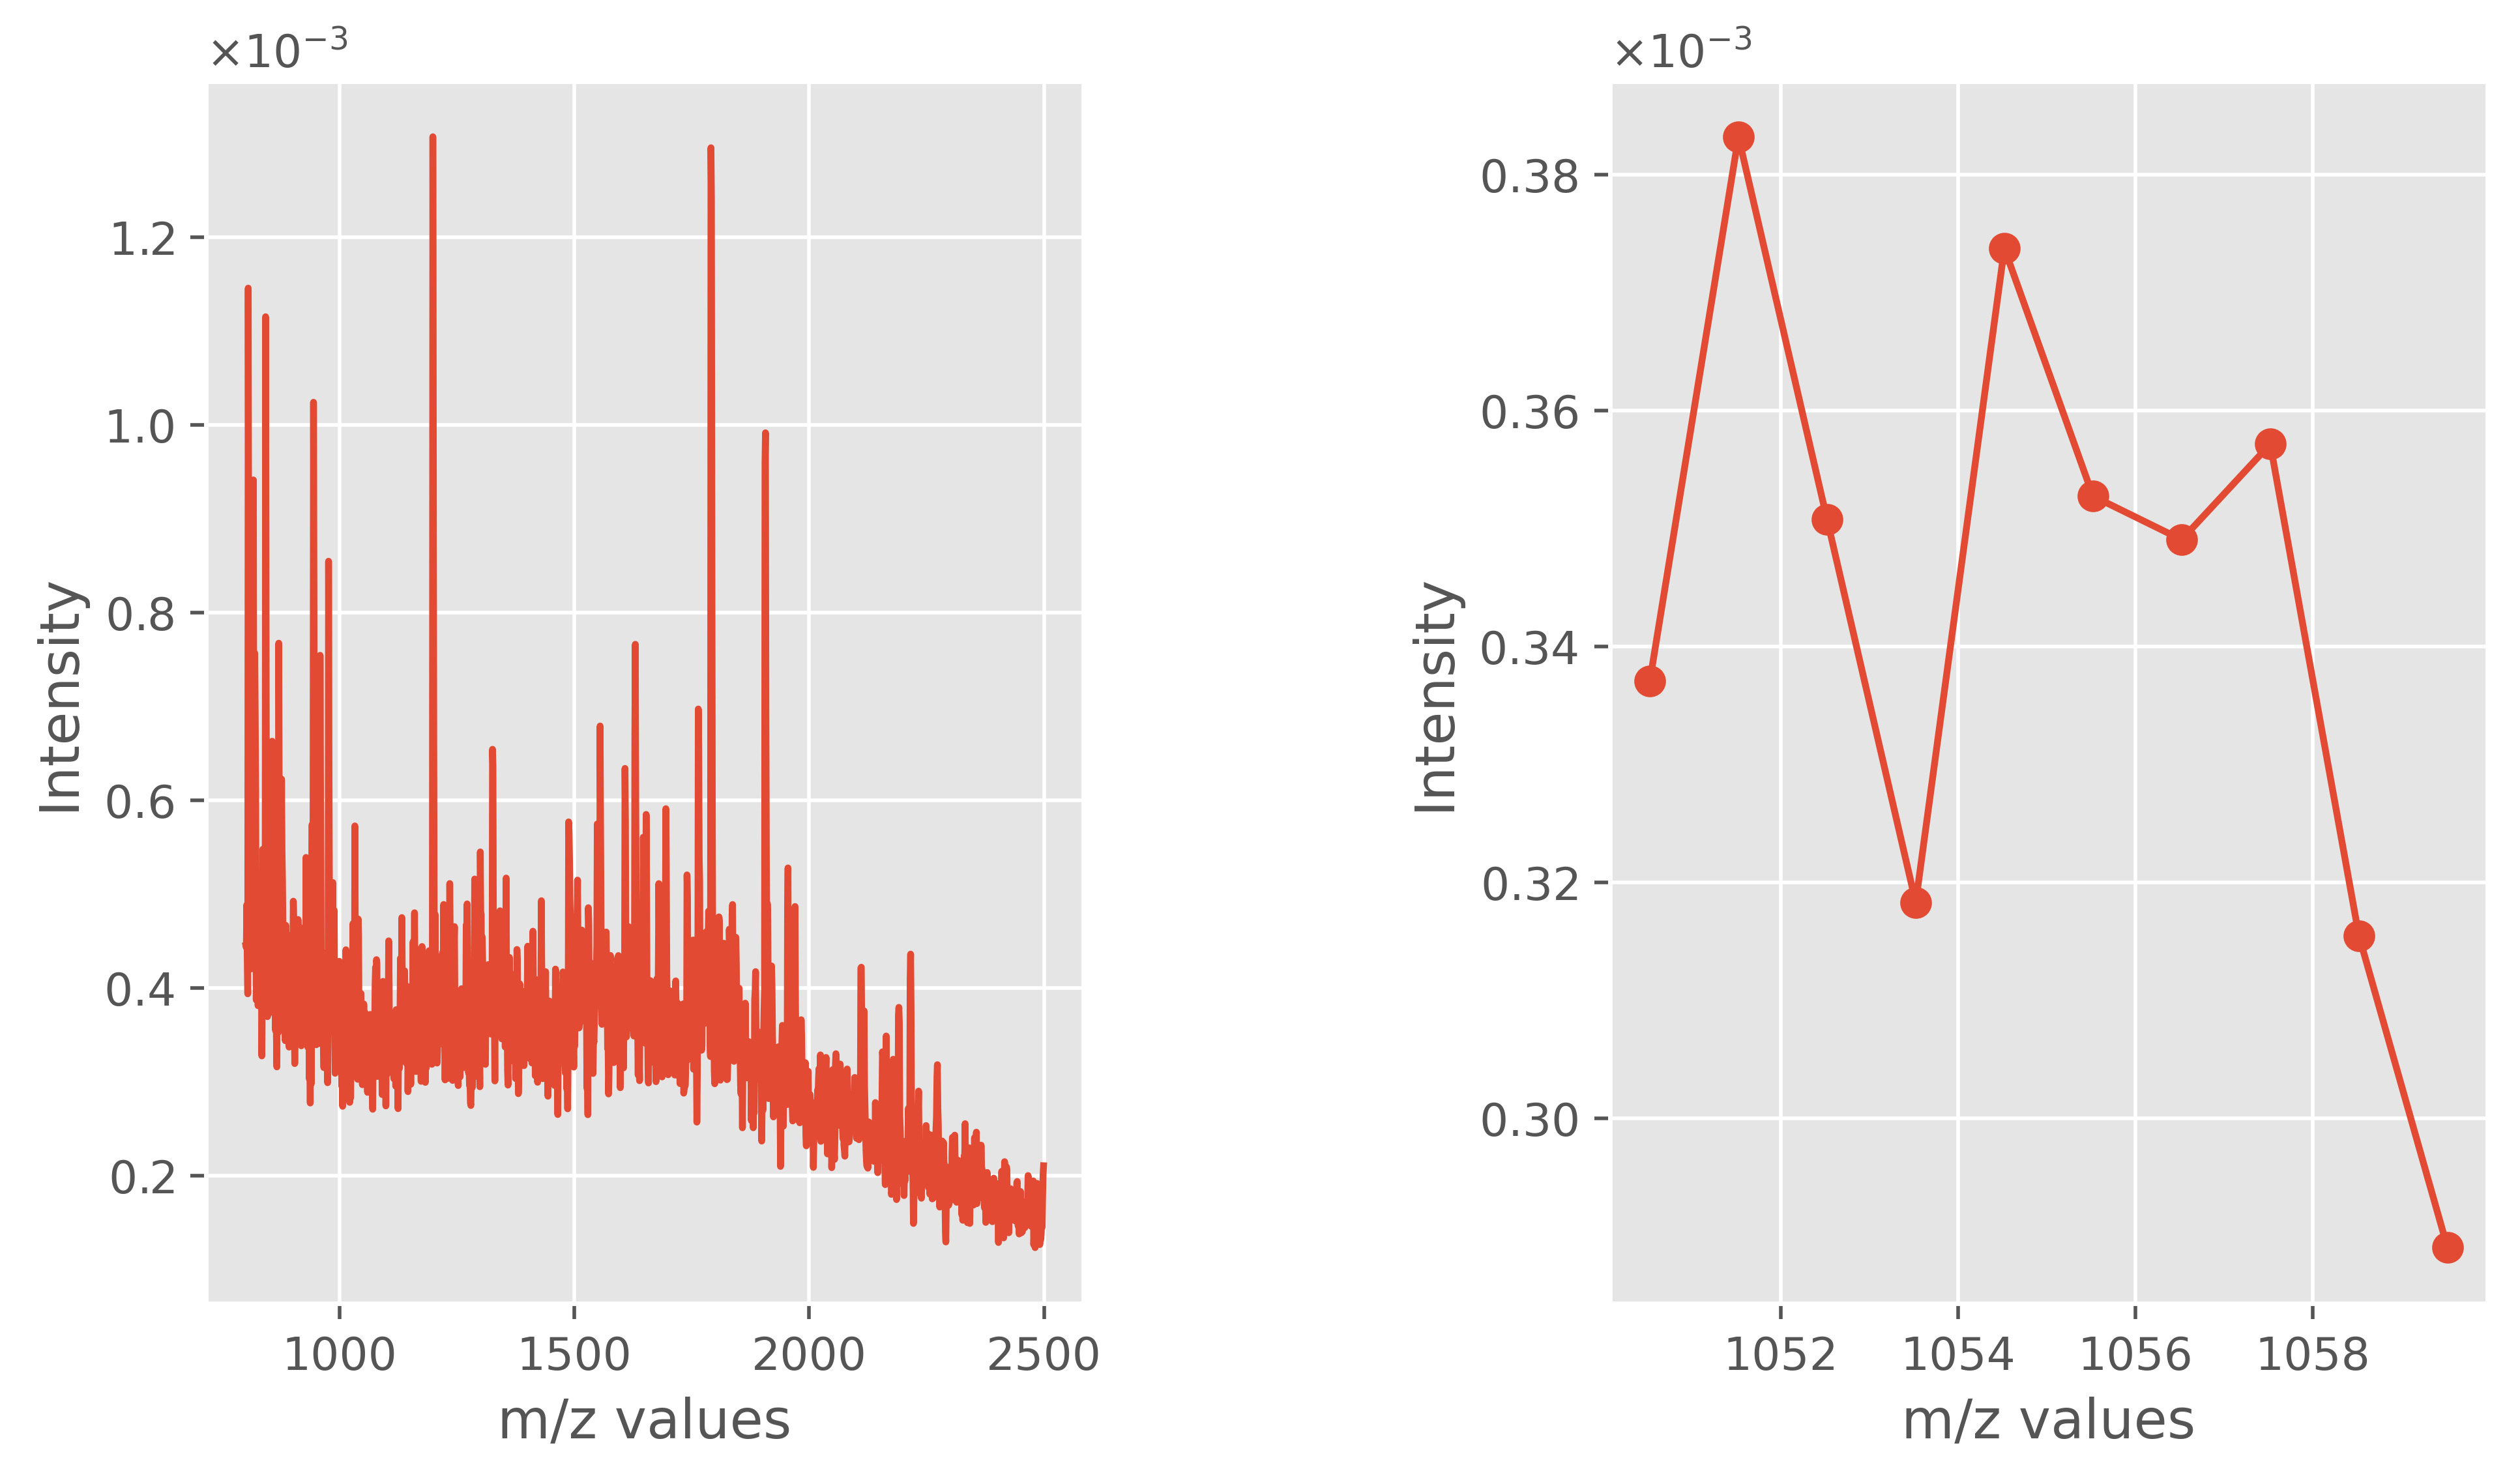

In [34]:
import matplotlib
matplotlib.style.use('ggplot')
s1 = X_values.loc[[22]]

fig = plt.figure(figsize=(5,5), dpi=500)

plt.subplot(1, 2, 1)
plt.plot(mz_values, np.transpose( X_values.loc[[22]]))
plt.ylabel('Intensity')
plt.xlabel('m/z values')

plt.ticklabel_format(axis='y',style='sci',scilimits=(-3, -3), useMathText = True)

plt.subplot(1, 2, 2) # index 2
plt.plot(mz_values[250:260], np.transpose( X_values.loc[[22]])[250:260], marker = 'o')
plt.ylabel('Intensity')
plt.xlabel('m/z values')


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.5,
                    top=0.85,
                    wspace=0.6,
                    hspace=0.4)

plt.ticklabel_format(axis='y',style='sci',scilimits=(-3, -3), useMathText = True)

plt.savefig("results/example_of_spectra.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#pd.DataFrame(X_k1).to_csv('intermediate_results/sk1.csv', index=False) 
#pd.DataFrame(X_k2).to_csv('intermediate_results/sk2.csv', index=False) 
#pd.DataFrame(X_k3).to_csv('intermediate_results/sk3.csv', index=False) 
#pd.DataFrame(X_k4).to_csv('intermediate_results/sk4.csv', index=False) 
#pd.DataFrame(X_k5).to_csv('intermediate_results/sk5.csv', index=False) 
#pd.DataFrame(X_k6).to_csv('intermediate_results/sk6.csv', index=False) 
#pd.DataFrame(X_k7).to_csv('intermediate_results/sk7.csv', index=False) 
#y.to_csv('intermediate_results/subtypes.csv', index = False)
#TMAs.to_csv('intermediate_results/tmas.csv', index = False)

